In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [26]:
from google.colab import drive
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')
# Go to the current folder
%cd /content/drive/MyDrive/Colab Notebooks/

file_path = "/content/drive/My Drive/Colab Notebooks/master_RMS.csv"
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [27]:
# Ensure correct column selection (features = columns 2-9, target = column 10)
feature_columns = df.columns[1:9]  # Select only EMG channel data (columns 2-9)
target_column = df.columns[9]  # Column 10 (class label)

NEXT CODE BLOCK SUPER IMPORTANT. IGNORE DATA CLASSED AS ZERO. FUCKS IT UP

In [28]:
# **Filter out rows where class == 0**
df = df[df[target_column] != 0]
df = df[df[target_column] != 7]

# Convert target column to categorical type (ensures proper color mapping)
df[target_column] = df[target_column].astype(str)  # Convert to string for discrete categories

In [29]:
df.head()

,instance,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
1,2,0.000019,0.000021,0.000021,0.000020,0.000020,0.000042,0.000025,0.000022,1.0
3,4,0.000783,0.000446,0.000142,0.000324,0.000355,0.000269,0.000329,0.000439,2.0
5,6,0.000122,0.000334,0.000099,0.000046,0.000222,0.000243,0.000081,0.000184,3.0
7,8,0.000081,0.000059,0.000099,0.000215,0.000666,0.000646,0.000219,0.000149,4.0
9,10,0.000025,0.000090,0.000028,0.000090,0.000425,0.000191,0.000074,0.000032,5.0


In [30]:
# Standardize data for t-SNE (helps with performance & accuracy)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_columns])

In [31]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)

# Add t-SNE results to DataFrame
df["tSNE-1"] = X_tsne[:, 0]
df["tSNE-2"] = X_tsne[:, 1]

<ipython-input-32-1d113a7b42fd>:6: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.scatterplot(x="tSNE-1", y="tSNE-2", hue=df[target_column], palette=palette, data=df, alpha=0.8, edgecolor="black")


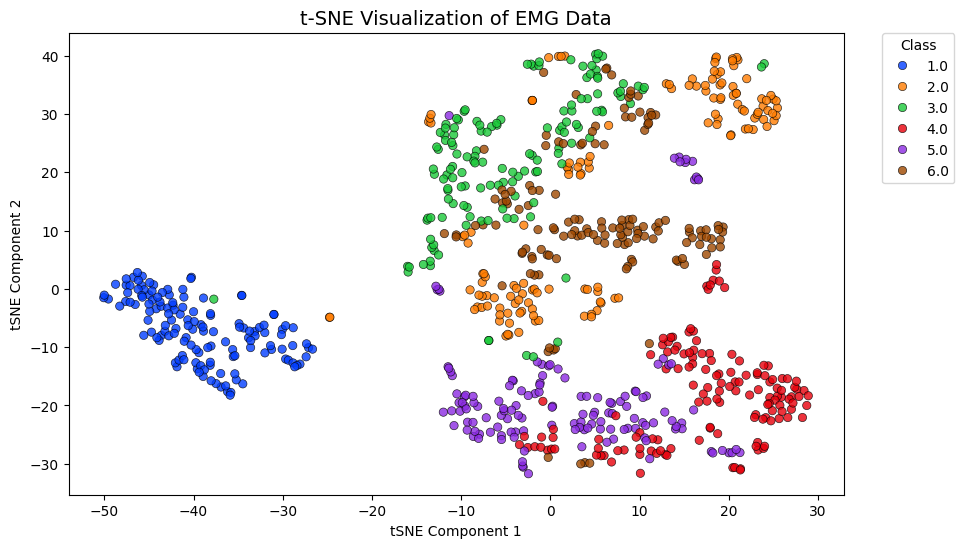

In [32]:
# Define a high-contrast color palette (e.g., 'tab10' or 'Set1' for categorical data)
palette = sns.color_palette("bright", n_colors=8)  # 8 distinct colors

# Plot t-SNE visualization with improved legend
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tSNE-1", y="tSNE-2", hue=df[target_column], palette=palette, data=df, alpha=0.8, edgecolor="black")

# Improve plot appearance
plt.title("t-SNE Visualization of EMG Data", fontsize=14)
plt.xlabel("tSNE Component 1")
plt.ylabel("tSNE Component 2")

# Improve legend placement
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

# Show plot
plt.show()

In [33]:
features_for_plot = list(feature_columns)

# Create a pairplot with a high-contrast color palette (using "tab10")
sns.pairplot(df, vars=features_for_plot, hue=target_column, palette="tab10", diag_kind="kde")

# Enhance plot appearance and display
plt.suptitle("Pairplot of EMG Features (Excluding Class 0)", y=1.02)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-53-e932c5d916cb>:98: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


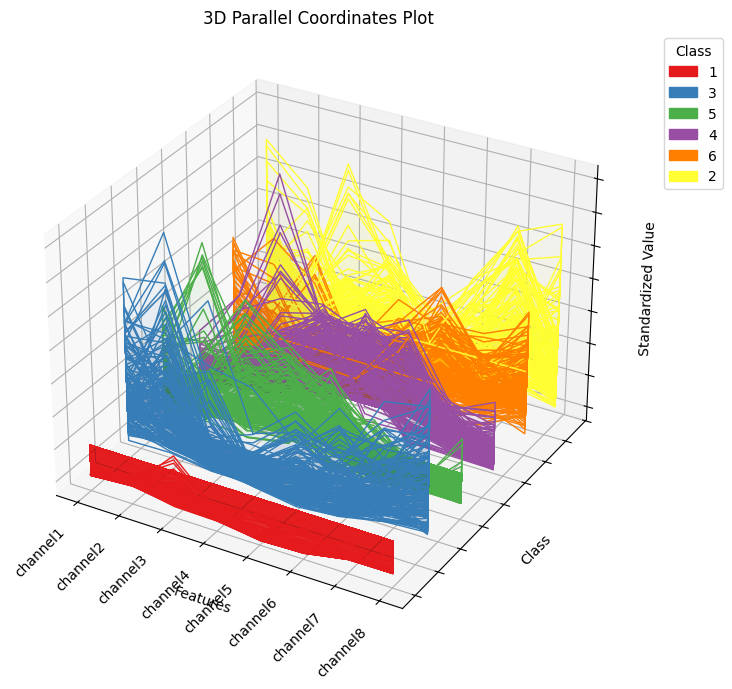

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # Enables 3D plotting
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import scipy.interpolate as spi

# Load the aggregated dataset
file_path = "master_RMS.csv"  # Update with correct path if needed
df = pd.read_csv(file_path)

# Define feature and target columns
# Features: columns 2-9; Target: column 10 (class)
feature_columns = df.columns[1:9]
target_column = df.columns[9]

# Filter out rows where class is 0
df = df[df[target_column] != 0]
df = df[df[target_column] != 7]

# Convert target column to float, then to int, then to string for consistent categorical mapping
df[target_column] = df[target_column].astype(float).astype(int).astype(str)

# Standardize the feature values for comparability
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Set up the 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# x positions corresponding to each feature (for the horizontal axis)
x = np.arange(len(feature_columns))

# MANUALLY rearrange the order of classes on the y axis.
# Change the order in this list as desired.
custom_order = ['1', '3', '5', '4', '6', '2']
# Retain only classes present in the DataFrame
custom_order = [c for c in custom_order if c in df[target_column].unique()]

# Use the y-axis to represent the class, with a fixed spacing
y_spacing = 3  # Adjust spacing as desired
class_mapping = {label: i * y_spacing for i, label in enumerate(custom_order)}

# Define a high-contrast color palette (using "Set1") for the classes
palette = sns.color_palette("Set1", n_colors=len(custom_order))
color_dict = {label: palette[i] for i, label in enumerate(custom_order)}

# Loop over each sample and plot a smoothed 3D line with filled area under the curve
for idx, row in df.iterrows():
    # Extract standardized feature values (to be used on the z-axis)
    z = row[feature_columns].values.astype(float)
    class_label = row[target_column]
    y_level = class_mapping[class_label]  # Determine y-level for this class

    # Create a smooth curve using cubic spline interpolation
    x_new = np.linspace(x.min(), x.max(), 8)  # Increase the number of points for smoothing
    spline = spi.make_interp_spline(x, z, k=3)
    z_smooth = spline(x_new)

    # Create corresponding y values (constant for this sample)
    y_smooth = np.full_like(x_new, fill_value=y_level, dtype=float)

    # Plot the smooth line with partial transparency
    ax.plot(x_new, y_smooth, z_smooth, color=color_dict[class_label], alpha=0.01)

    # Create polygon for the filled area under the curve
    polygon_points = []
    baseline = 0  # Define baseline for z-axis filling
    polygon_points.append((x_new[0], y_level, baseline))
    for xi, zi in zip(x_new, z_smooth):
        polygon_points.append((xi, y_level, zi))
    polygon_points.append((x_new[-1], y_level, baseline))

    # Add the polygon with partial transparency
    poly = Poly3DCollection([polygon_points], color=color_dict[class_label], alpha=0.01)
    ax.add_collection3d(poly)

# Set x-axis tick labels to feature names
ax.set_xticks(x)
ax.set_xticklabels(feature_columns, rotation=45, ha='right')
ax.set_xlabel("Features")
ax.set_ylabel("Class")
ax.set_zlabel("Standardized Value")
ax.set_title("3D Parallel Coordinates Plot")

# Remove tick labels for the y and z axes
ax.set_yticklabels([])
ax.set_zticklabels([])

# Create custom legend mapping colors to class labels
patches = [mpatches.Patch(color=color_dict[label], label=label) for label in custom_order]
ax.legend(handles=patches, title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


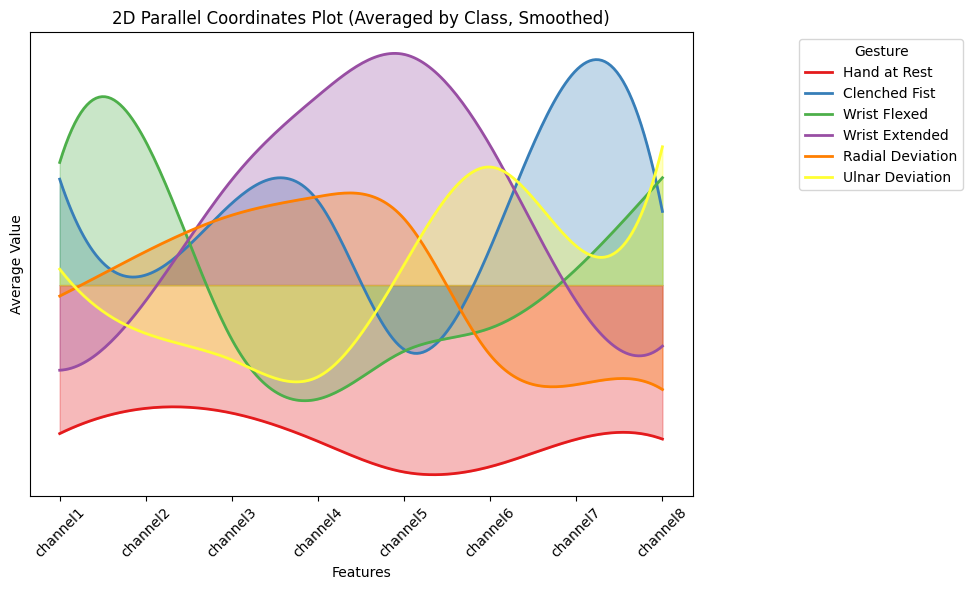

In [56]:
from scipy.interpolate import make_interp_spline

# Compute the average for every feature grouped by class
avg_df = df.groupby('class')[feature_columns].mean().reset_index()

# Create x positions corresponding to each feature
x = np.arange(len(feature_columns))
# Create a smoother x axis for interpolation (more points)
x_smooth = np.linspace(x.min(), x.max(), 200)

# Define custom labels for the classes
label_map = {
    '1': 'Hand at Rest',
    '2': 'Clenched Fist',
    '3': 'Wrist Flexed',
    '4': 'Wrist Extended',
    '5': 'Radial Deviation',
    '6': 'Ulnar Deviation'
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Get the list of classes and define a high-contrast color palette
classes = sorted(avg_df['class'].unique())
palette = sns.color_palette("Set1", n_colors=len(classes))
color_dict = {cls: palette[i] for i, cls in enumerate(classes)}

# Plot each class's average curve (smoothed) and fill the area under the curve
for idx, row in avg_df.iterrows():
    cls = row['class']
    # Original average values for the features
    y = row[feature_columns].values.astype(float)

    # Create a cubic spline interpolation for a smooth curve
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)

    # Plot the smoothed line with the custom label
    plt.plot(x_smooth, y_smooth, label=label_map.get(cls, cls),
             color=color_dict[cls], linewidth=2)
    # Fill the area under the smoothed curve
    plt.fill_between(x_smooth, y_smooth, alpha=0.3, color=color_dict[cls])

# Customize the x-axis and remove y-axis tick labels
plt.xticks(x, feature_columns, rotation=45)
plt.xlabel("Features")
plt.ylabel("Average Value")
plt.title("2D Parallel Coordinates Plot (Averaged by Class, Smoothed)")

# Remove y-axis tick labels
plt.yticks([])

# Move the legend to the far right outside the graph
plt.legend(title="Gesture", bbox_to_anchor=(1.15, 1), loc="upper left")

plt.tight_layout()
plt.show()
